In [93]:
import numpy as np 
from numpy import inf
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

# Все написанные функции лежат здесь
from model_functions import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Подготовка

### Данные

In [2]:
data_month=pd.read_excel('data_case.xlsx',sheet_name='month')
data_quarter=pd.read_excel('data_case.xlsx',sheet_name='quarter')
descriptions=pd.read_excel('data_case.xlsx',sheet_name='description')

### Признаки по типам

Разделяем признаки по типам для более удобной аугментации (data augmentation)

In [3]:
# Объёмные признаки (не цены, не индексы, не доходности)
volume_features=[
    'stock_market_volume', 
    'goods_market_volume',
    'sber_volume', 
    'sber_orders',
    'spy_volume', 
    'dji_volume',
    'ixic_volume',
    'money_m2', 
    'money_m0',
    'credit_volume',
    'rkpdh_volume', 
    'vnok_volume',
    'im_volume',
    'ex_volume', 
    'gdp_volume',
    'product_taxes_volume', 
    'income_percapita_volume'
]

# Ценовые признаки
price_features=[
    'rtsi_max',
    'rtsi_min', 
    'rtsi_last', 
    'sber_last',
    'spy_close', 
    'dji_close', 
    'ixic_close',
    'brent_price',
    'real_estate_2_price', 
    'real_estate_1_price'
]

# Темпы роста (индексы)
index_features=[
    'cpi_all',
    'cpi_cars',
    'vi_retail',
    'vi_gdp',
    'pi_gdp',
    'vi_vnok',
    'vi_rkpdh'
]

# Темпы прироста (доходности)
delta_features=[
    'ofz_1', 
    'ofz_10', 
    'ofz_30'
]

# Прочие признаки
other_features=[
    'ofz_diff_10_1',
    'ofz_diff_30_10', 
    'ofz_diff_30_1',
    'unempl_rate', 
    'int_rate'
]

### Словарь с признаками

Для каждого типа задачи (месяц/квартал) создаём свои наборы признаков

In [4]:
features_dict={
    'month':
            {
             'volume_features':[x for x in data_month.columns if x in volume_features],
             'price_features':[x for x in data_month.columns if x in price_features],
             'index_features':[x for x in data_month.columns if x in index_features],
             'delta_features':[x for x in data_month.columns if x in delta_features],
             'other_features':[x for x in data_month.columns if x in other_features]
            },
    'quarter':
            {
             'volume_features':[x for x in data_quarter.columns if x in volume_features],
             'price_features':[x for x in data_quarter.columns if x in price_features],
             'index_features':[x for x in data_quarter.columns if x in index_features],
             'delta_features':[x for x in data_quarter.columns if x in delta_features],
             'other_features':[x for x in data_quarter.columns if x in other_features]
            }
}

## 2. Генерация признаков

### Генерим признаки

In [6]:
# Темпы роста/прироста
data_growth=gen_growth(data_month,data_month.drop(['period','target'],axis=1).columns)
# Лаги
data_lag_1_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,1)
data_lag_1_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,1)
data_lag_2_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,2)
data_lag_2_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,2)
data_lag_3_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,3)
data_lag_3_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,3)
# Объединяем
features=data_growth.merge(data_lag_1_all,on='period'). \
                          merge(data_lag_1_growth,on='period'). \
                          merge(data_lag_2_all,on='period'). \
                          merge(data_lag_2_growth,on='period'). \
                          merge(data_lag_3_all,on='period'). \
                          merge(data_lag_3_growth,on='period') 
# Удаляем пропуски
# data_model=data_model.dropna()
print(f'Число наблюдений: {len(features)}')
print(f'Начальный период: {features["period"].min()}')
print(f'Конечный период: {features["period"].max()}')

Число наблюдений: 162
Начальный период: 2009-08-01 00:00:00
Конечный период: 2023-01-01 00:00:00


### Генерим варианты целевой переменной

In [27]:
# Вариант 1. Исходный таргет
data_model_target=features.merge(data_month[['period','target']],on='period')
# Вариант 2. Темпы прироста
target_growth=gen_growth(data_month,['target'])
data_model_delta=features.merge(target_growth[['period','delta_rate_target']],on='period')
data_model_delta.rename({'delta_rate_target': 'target'},inplace=True,axis=1)
# Вариант 3. Первые разности темпов прироста
diff_delta=pd.DataFrame({'period':data_month.period[2:], 
                          'target':target_growth['delta_rate_target'][1:].values-target_growth['delta_rate_target'][:-1].values })
data_model_diff_delta=features.merge(diff_delta[['period','target']],on='period')

## 3. Отбор признаков

Для отбора признаков используется shap (в качестве регрессора взят LGBMRegressor, т.к. он работает с пропусками и inf)

### Считаем shap для каждой задачи

In [31]:
%%time
df_shap_target = calculate_shap_importance(data_model_target,
                                           data_model_target.drop(['period','target'],axis=1).columns.tolist())
df_shap_delta = calculate_shap_importance(data_model_delta,
                                          data_model_delta.drop(['period','target'],axis=1).columns.tolist())
df_shap_diff = calculate_shap_importance(data_model_diff_delta,
                                          data_model_diff_delta.drop(['period','target'],axis=1).columns.tolist())

Wall time: 426 ms


### Отбираем top_n признаков для каждой задачи

In [112]:
top_n=30

features_list_target=df_shap_target.head(top_n)['shap_value'].index.tolist()
features_list_delta=df_shap_delta.head(top_n)['shap_value'].index.tolist()
features_list_diff_delta=df_shap_diff.head(top_n)['shap_value'].index.tolist()

## 4. Baseline (LGBMRegressor)

### 4.1. Целевая переменная - исходный таргет

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),99.76,-1570.08,16.74
MAPE (%),1.52,16.55,9.89


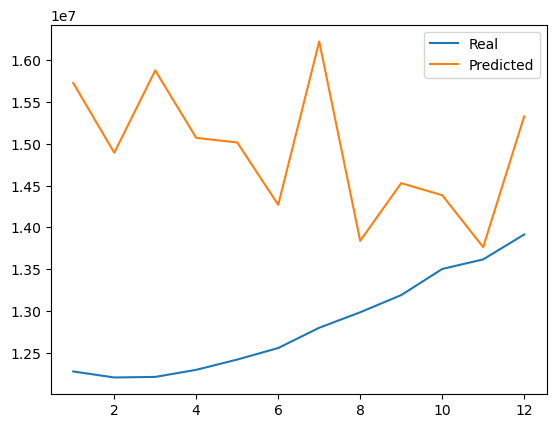

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),99.78,-112.51,2.13
MAPE (%),1.51,9.80,5.49


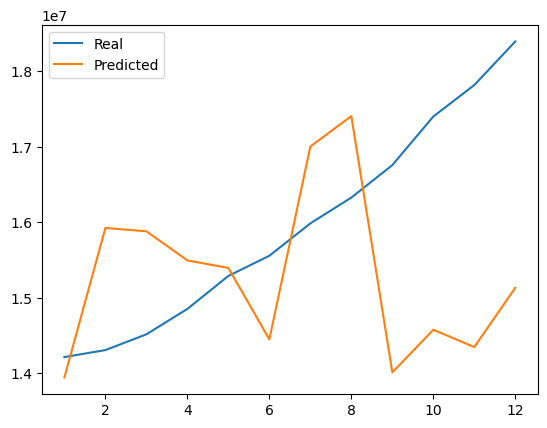

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),99.83,-164.07,2.64
MAPE (%),1.12,9.13,7.15


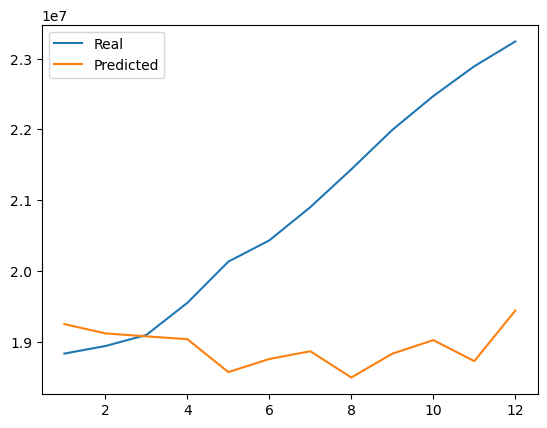

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),99.84,-7.48,1.07
MAPE (%),1.09,4.18,2.83


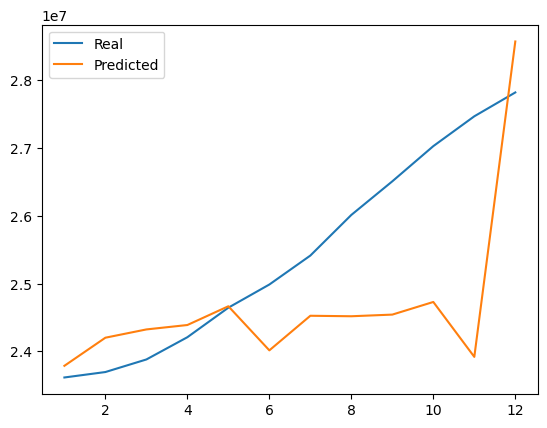

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),99.84,50.03,0.50
MAPE (%),1.12,2.47,1.21


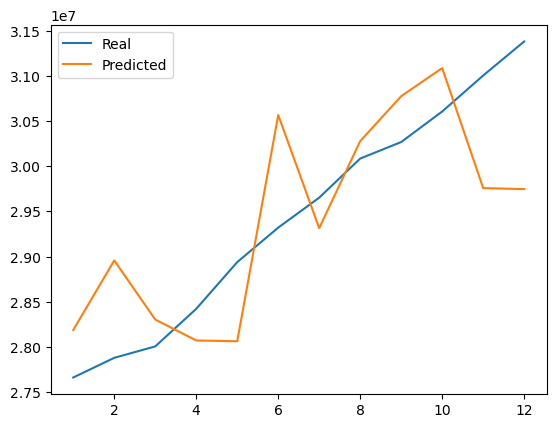

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),99.84,-561.93,6.63
MAPE (%),1.10,2.09,0.90


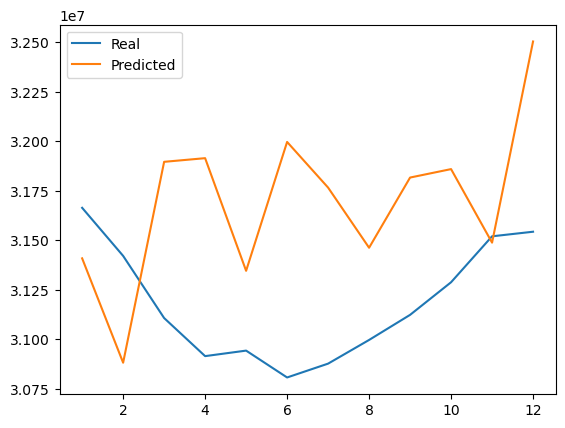

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),99.85,-696.81,7.98
MAPE (%),0.99,2.45,1.47


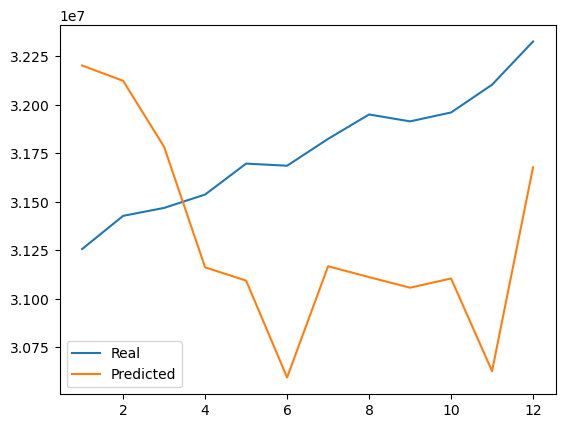

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),99.84,-209.41,3.10
MAPE (%),1.06,3.76,2.55


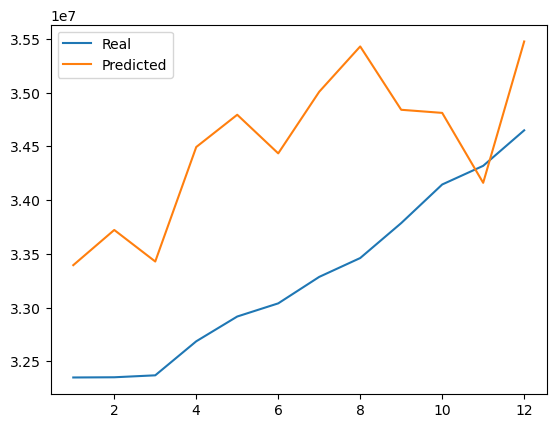

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),99.83,28.25,0.72
MAPE (%),1.13,3.25,1.88


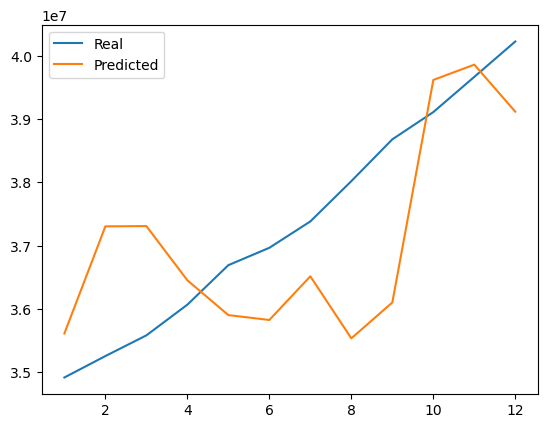

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),99.83,3.66,0.96
MAPE (%),1.09,2.49,1.28


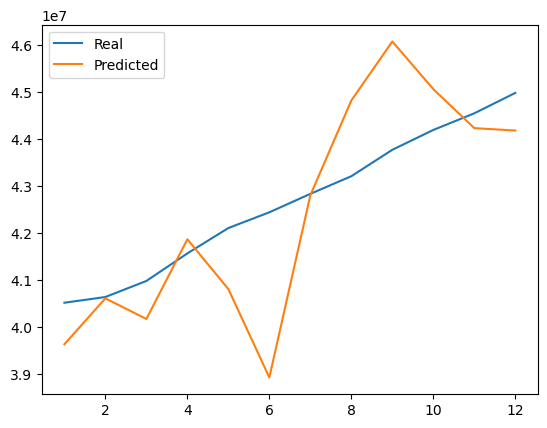

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),99.82,-181.28,2.82
MAPE (%),1.12,5.21,3.65


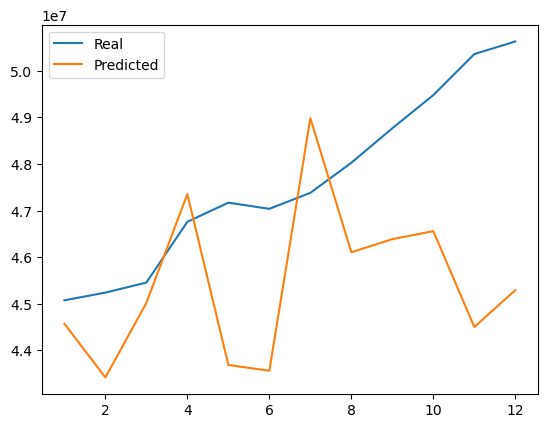

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),99.75,65.96,0.34
MAPE (%),1.29,2.88,1.23


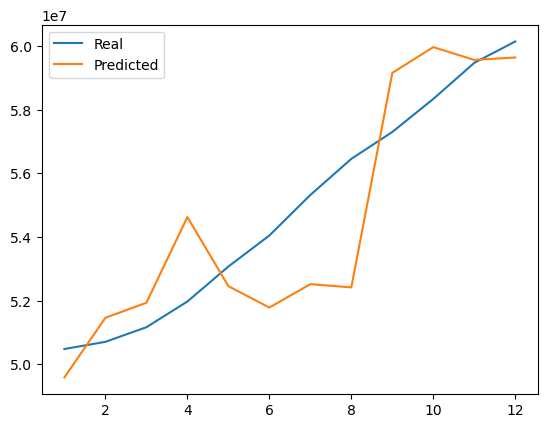

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),99.05,-505.14,6.10
MAPE (%),1.23,11.92,8.69


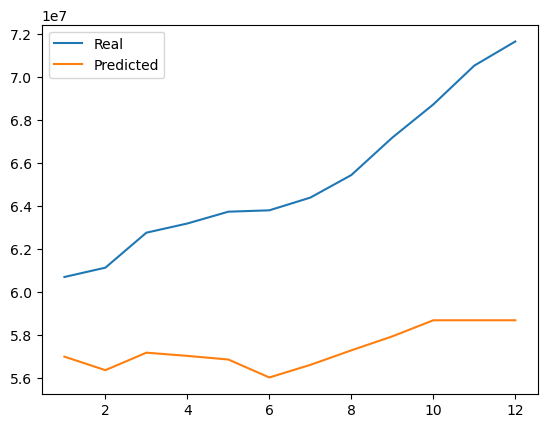

In [113]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_target[['period','target']+features_list_target]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.2. Целевая переменная - темпы прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),97.24,-4.59,1.05
MAPE (%),26.73,335.79,11.56


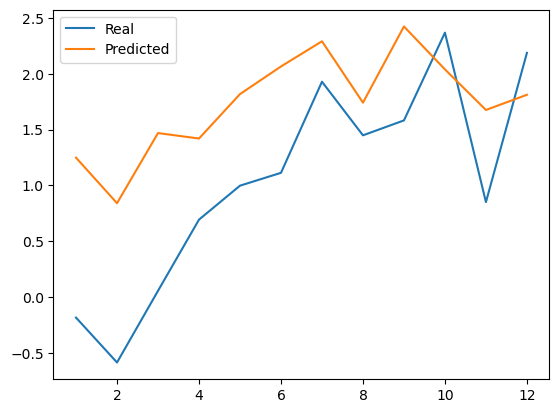

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),97.36,11.72,0.88
MAPE (%),27.40,26.20,0.04


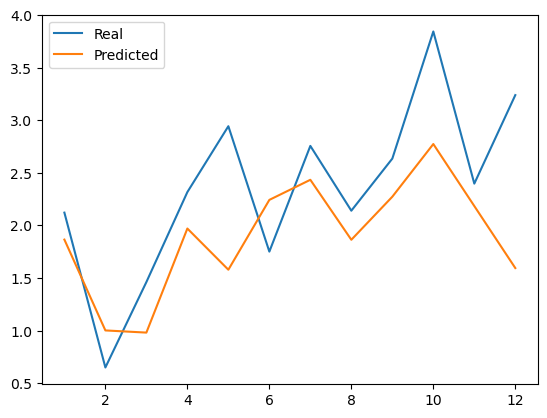

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),97.21,27.58,0.72
MAPE (%),24.63,29.19,0.19


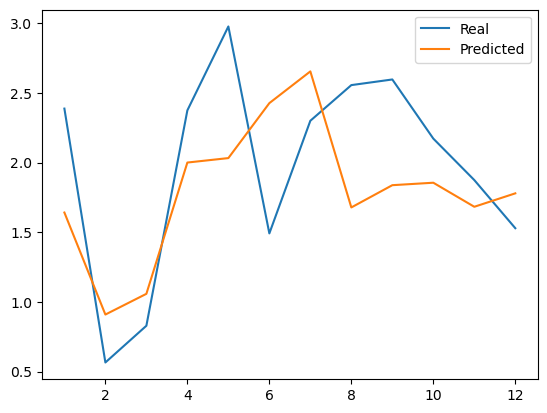

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),97.65,56.73,0.42
MAPE (%),28.00,20.78,0.26


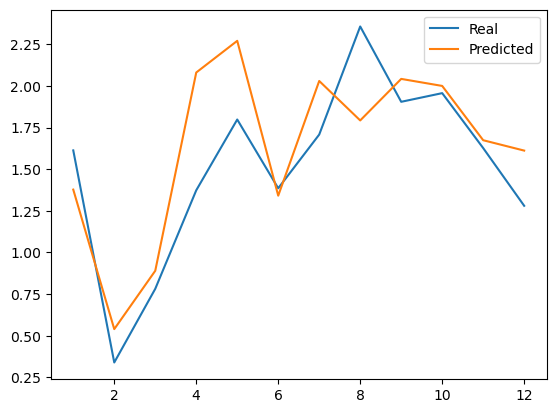

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),97.58,-70.99,1.73
MAPE (%),31.32,77.48,1.47


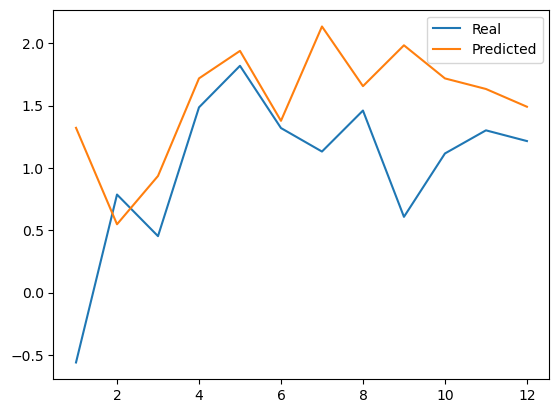

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),97.17,-4.08,1.04
MAPE (%),20.34,92.92,3.57


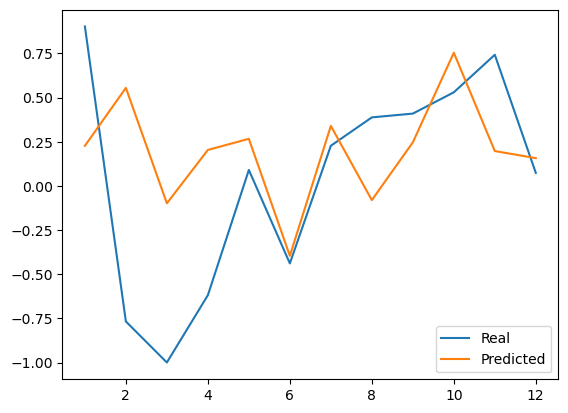

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),97.07,25.32,0.74
MAPE (%),24.42,142.73,4.84


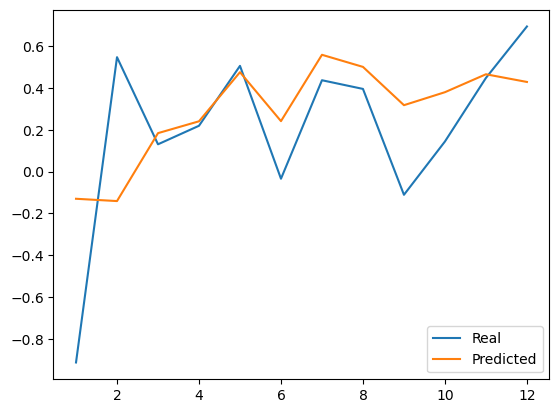

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),97.38,29.08,0.70
MAPE (%),17.19,255.34,13.85


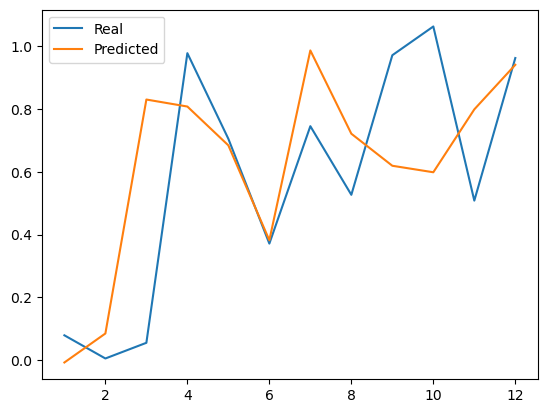

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),97.44,-33.40,1.34
MAPE (%),31.22,23.57,0.25


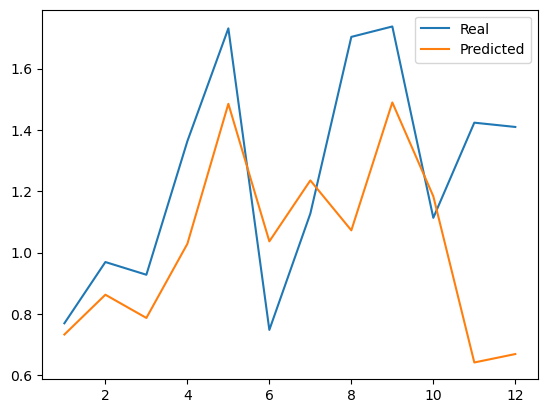

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),97.61,-68.00,1.70
MAPE (%),21.55,41.87,0.94


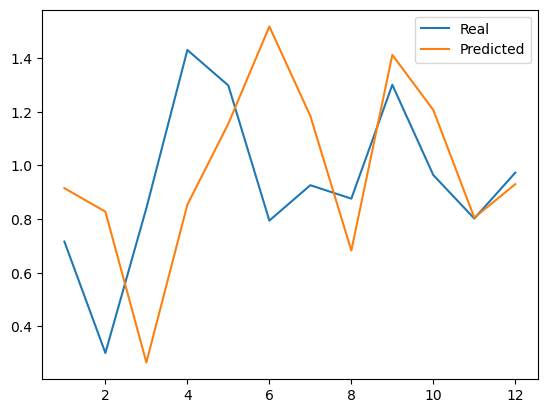

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),97.43,45.51,0.53
MAPE (%),36.31,76.29,1.10


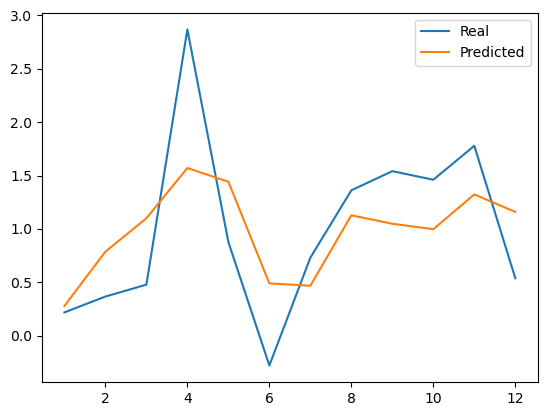

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),97.79,21.89,0.78
MAPE (%),17.97,66.35,2.69


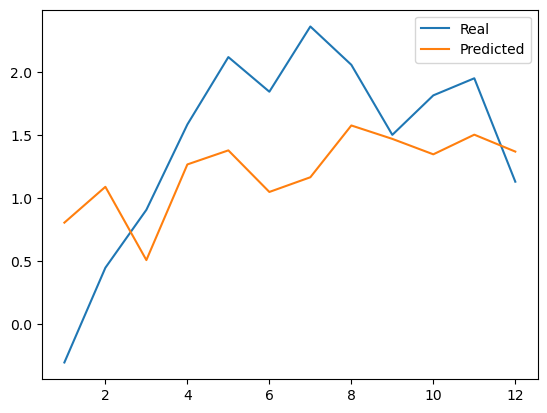

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),97.15,42.83,0.56
MAPE (%),35.41,66.40,0.88


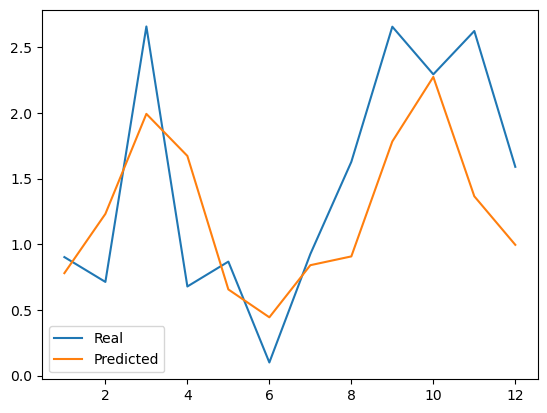

In [114]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_delta[['period','target']+features_list_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.3 Целевая переменная - первые разности темпов прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),96.21,26.68,0.72
MAPE (%),38.34,104.45,1.72


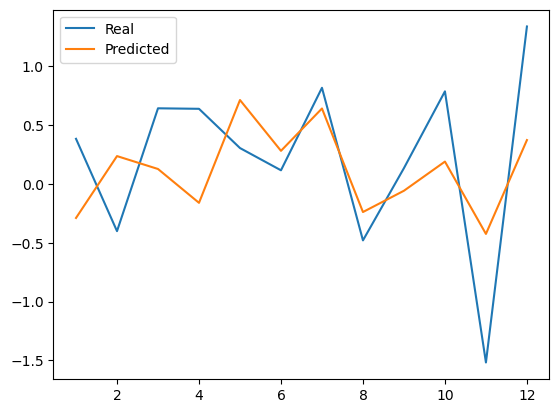

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),96.06,51.71,0.46
MAPE (%),40.67,74.29,0.83


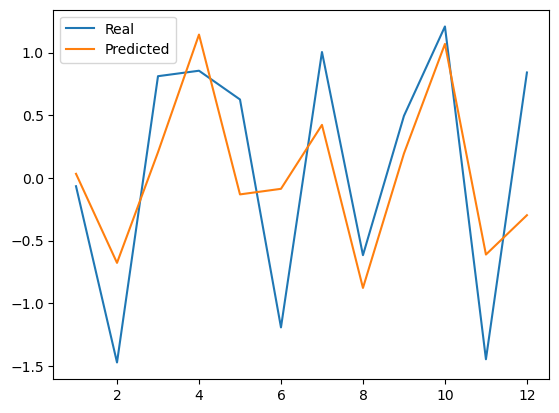

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),95.93,59.06,0.38
MAPE (%),41.36,162.31,2.92


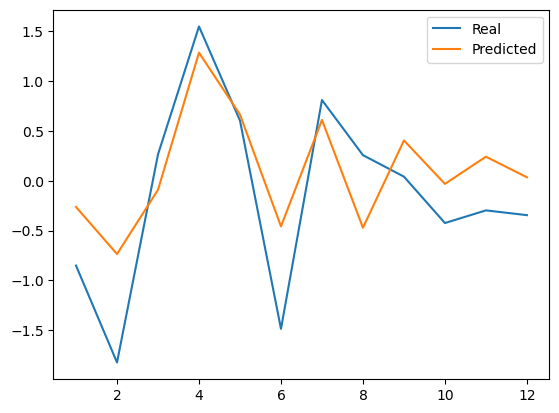

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),96.35,-25.02,1.26
MAPE (%),42.67,167.70,2.93


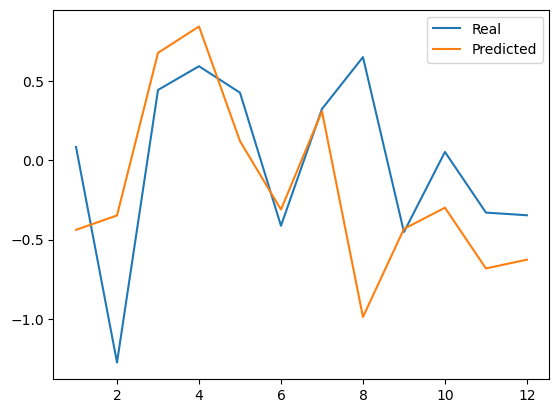

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),95.69,18.52,0.81
MAPE (%),45.58,120.93,1.65


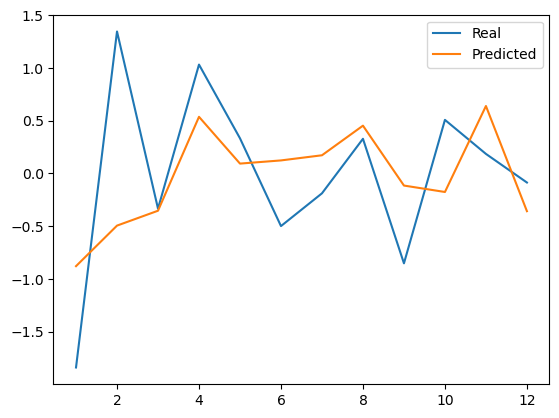

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),95.85,5.24,0.95
MAPE (%),35.06,381.47,9.88


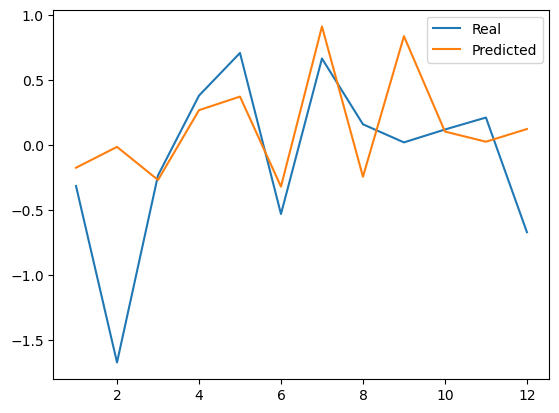

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),95.88,25.96,0.73
MAPE (%),41.43,102.46,1.47


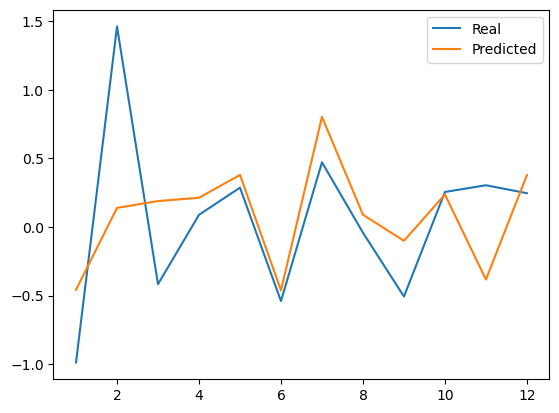

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),95.95,21.91,0.77
MAPE (%),45.57,142.51,2.13


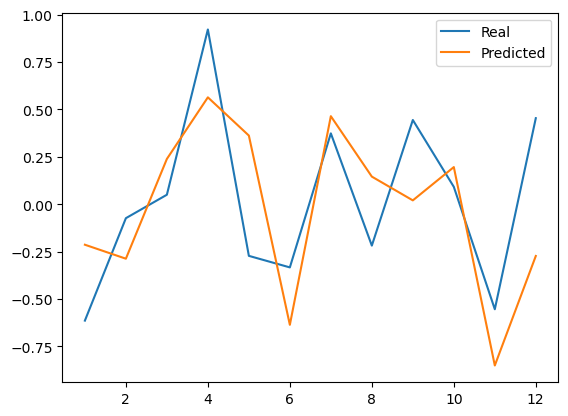

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),95.99,-14.21,1.15
MAPE (%),42.02,332.54,6.91


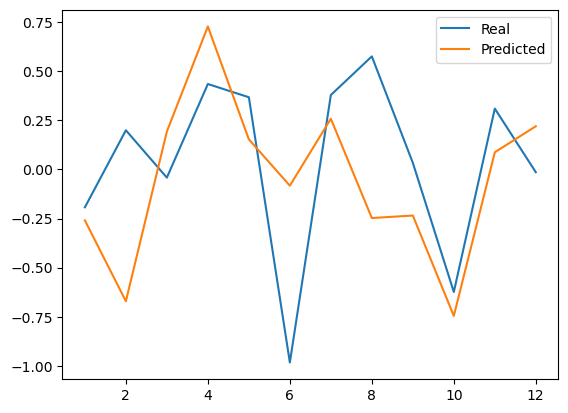

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),95.91,6.16,0.94
MAPE (%),41.40,156.53,2.78


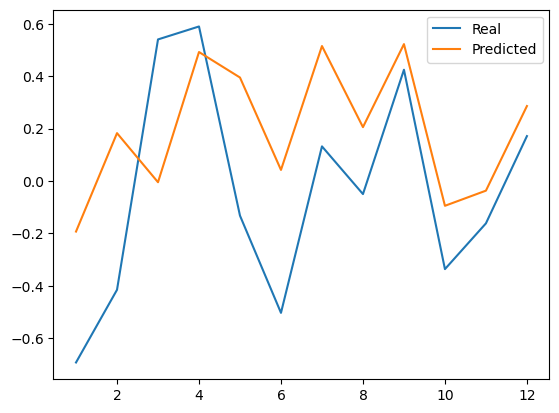

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),95.70,59.04,0.38
MAPE (%),38.23,85.67,1.24


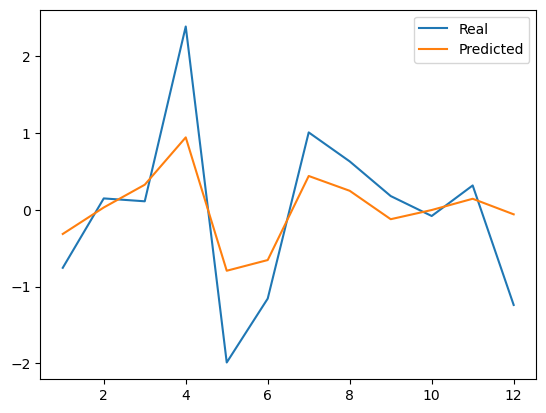

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),96.37,25.62,0.73
MAPE (%),42.08,100.43,1.39


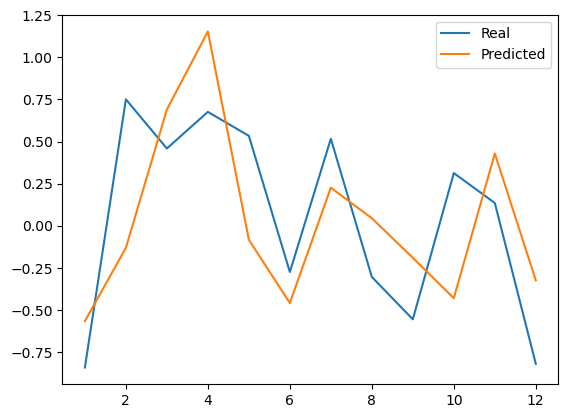

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),96.24,18.09,0.81
MAPE (%),39.99,115.04,1.88


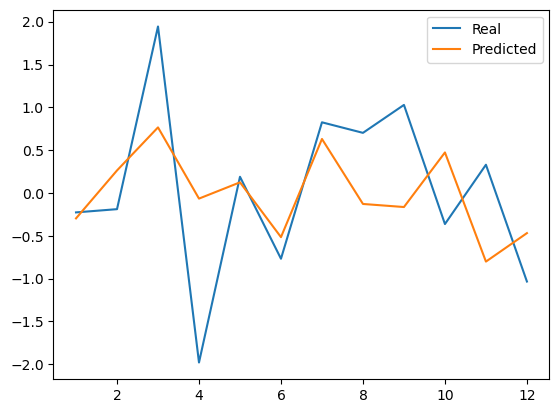

In [115]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_diff_delta[['period','target']+features_list_diff_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

## 5. Baseline (LinearRegression)

### Подготовим данные для модели (обработаем пропуски и inf)

In [116]:
# Обрабатываем пропуски
data_model_target_lr=data_model_target.fillna(data_model_target.median())
data_model_delta_lr=data_model_delta.fillna(data_model_delta.median())
data_model_diff_delta_lr=data_model_diff_delta.fillna(data_model_diff_delta.median())
# Обрабатываем inf
data_model_target_lr.replace([np.inf, -np.inf], 0, inplace=True)
data_model_delta_lr.replace([np.inf, -np.inf], 0, inplace=True)
data_model_diff_delta_lr.replace([np.inf, -np.inf], 0, inplace=True)

### 51. Целевая переменная - исходный таргет

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),98.81,-6788.31,69.70
MAPE (%),4.11,26.46,5.44


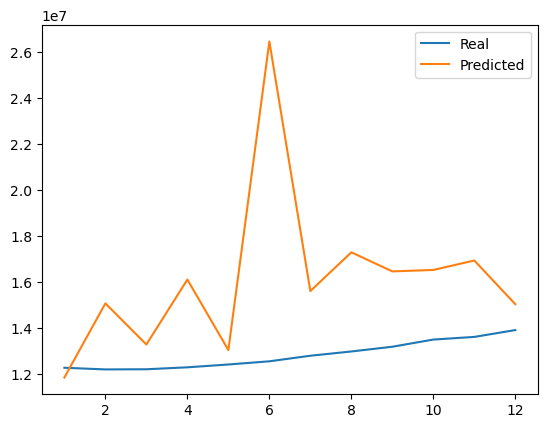

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),98.67,-13.86,1.14
MAPE (%),4.39,7.15,0.63


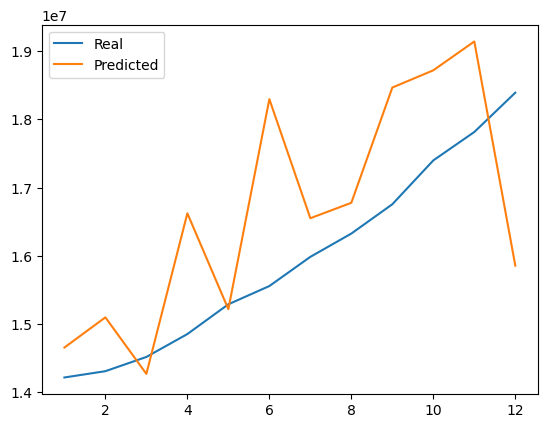

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),98.74,22.10,0.78
MAPE (%),4.50,5.09,0.13


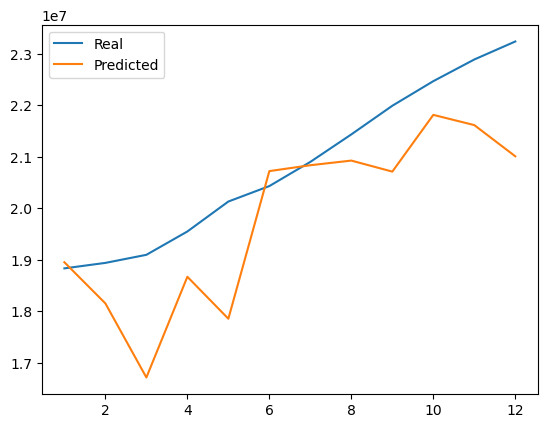

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),98.85,-129.44,2.31
MAPE (%),4.38,7.64,0.74


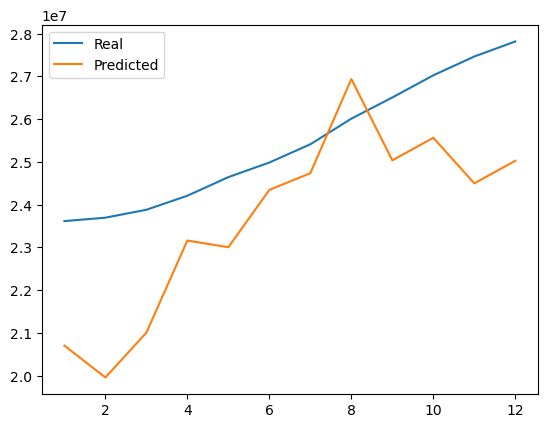

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),98.8,-35.12,1.36
MAPE (%),4.5,3.97,0.12


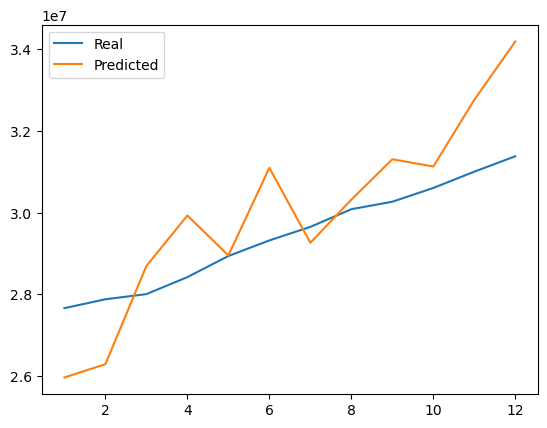

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),98.84,-4719.84,48.75
MAPE (%),4.41,5.61,0.27


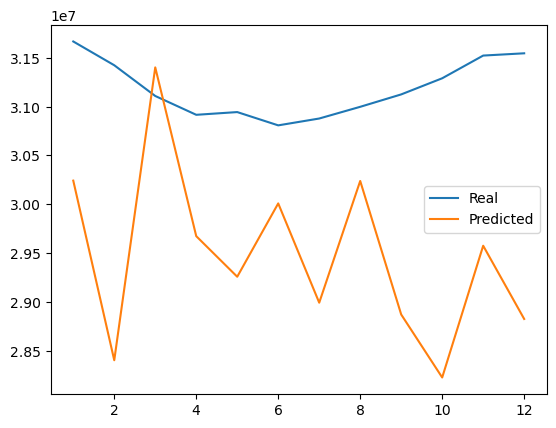

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),98.82,-1937.70,20.61
MAPE (%),4.53,3.36,0.26


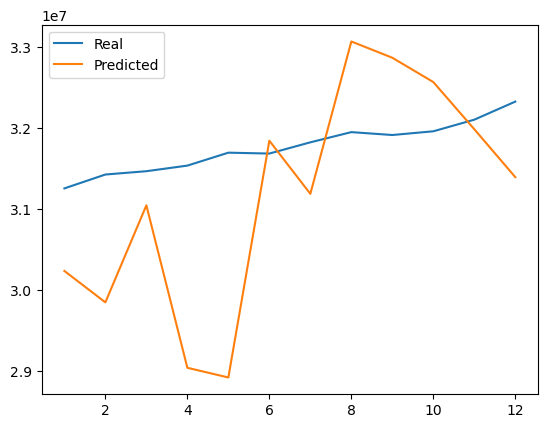

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),98.87,-576.92,6.84
MAPE (%),4.35,4.60,0.06


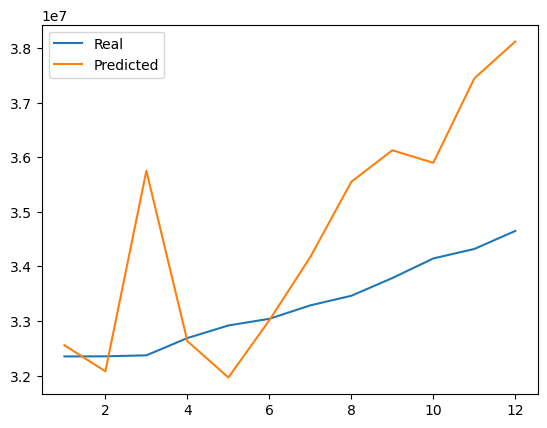

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),99.11,-477.29,5.82
MAPE (%),4.14,10.00,1.42


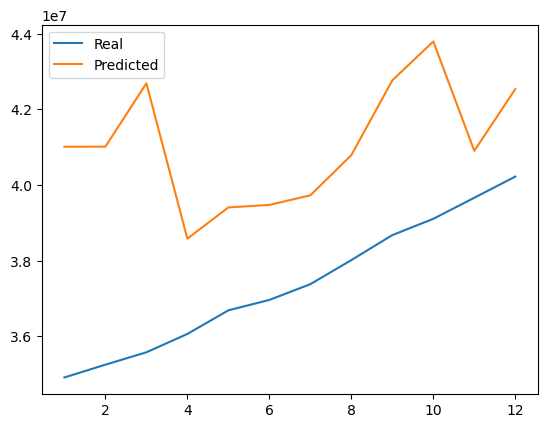

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),98.99,-817.98,9.26
MAPE (%),4.32,10.18,1.36


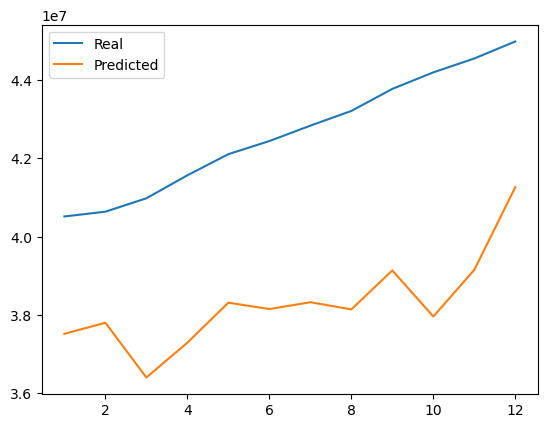

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),98.98,-552.46,6.58
MAPE (%),4.18,9.05,1.17


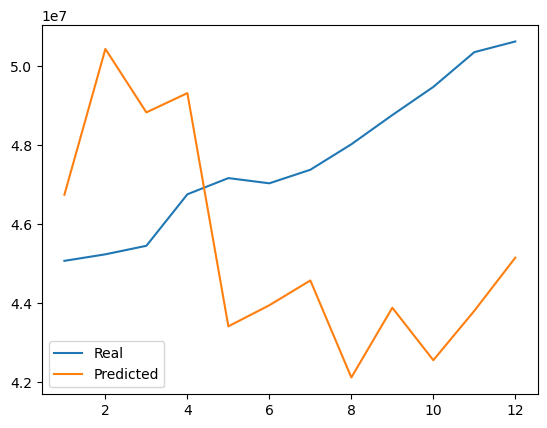

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),98.81,-30.61,1.31
MAPE (%),4.26,5.29,0.24


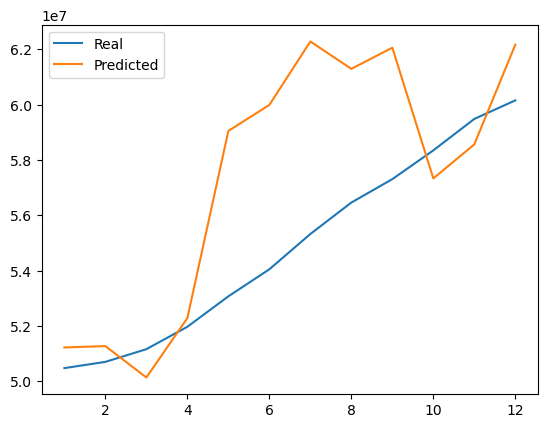

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),99.63,-2.469028e+08,2478197.85
MAPE (%),2.47,2.349510e+03,950.22


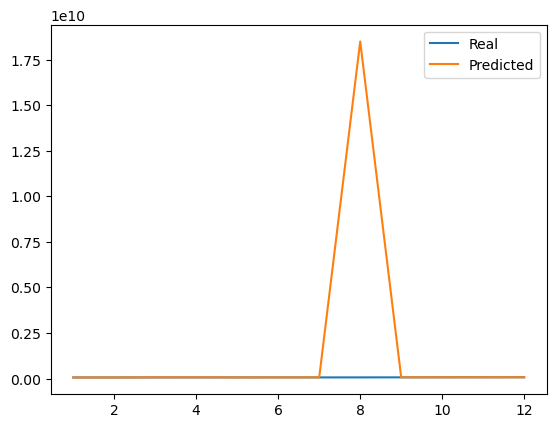

In [117]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_target_lr[['period','target']+features_list_target]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.2. Целевая переменная - темпы прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),73.98,57.86,0.22
MAPE (%),54.99,189.82,2.45


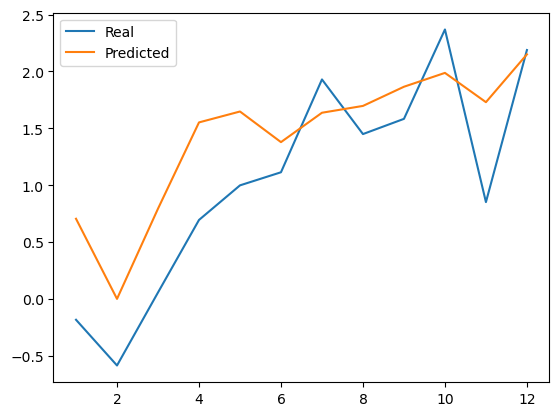

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),71.16,18.54,0.74
MAPE (%),65.93,23.99,0.64


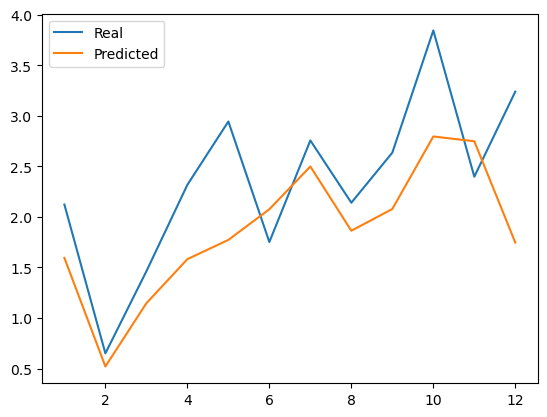

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),74.69,-8.65,1.12
MAPE (%),65.27,30.39,0.53


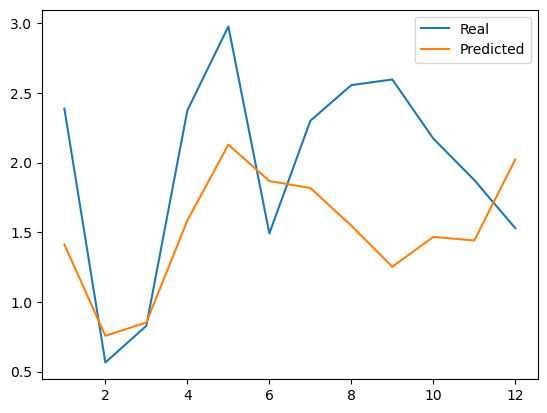

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),74.43,-3961.65,54.23
MAPE (%),76.04,90.13,0.19


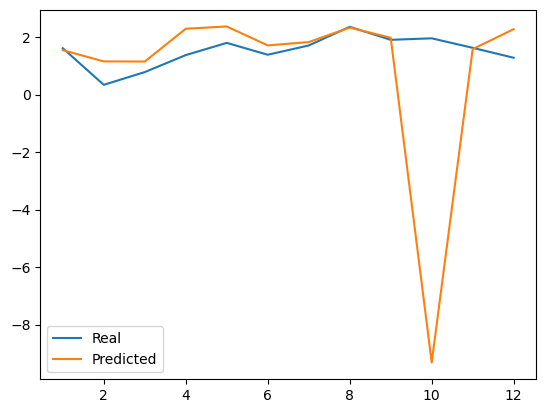

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),77.23,-86.75,2.12
MAPE (%),75.31,82.25,0.09


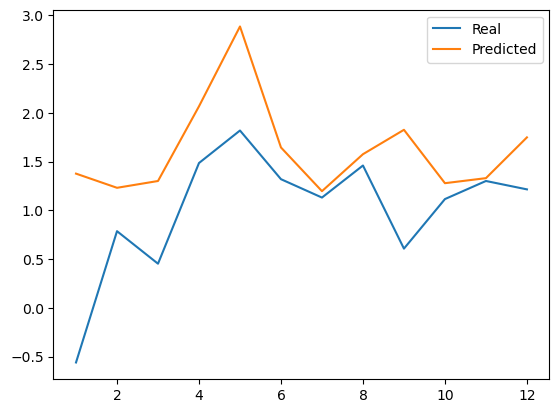

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),71.06,20.10,0.72
MAPE (%),60.92,94.25,0.55


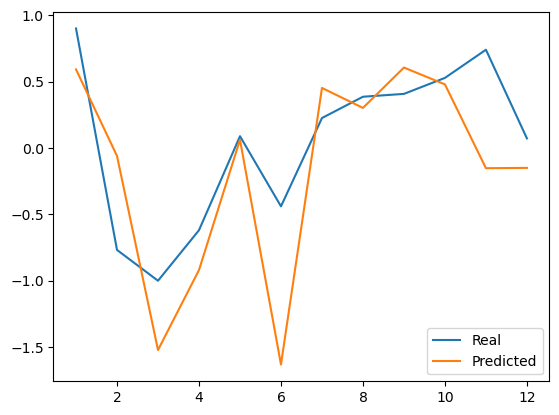

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),72.89,-42.25,1.58
MAPE (%),75.15,122.53,0.63


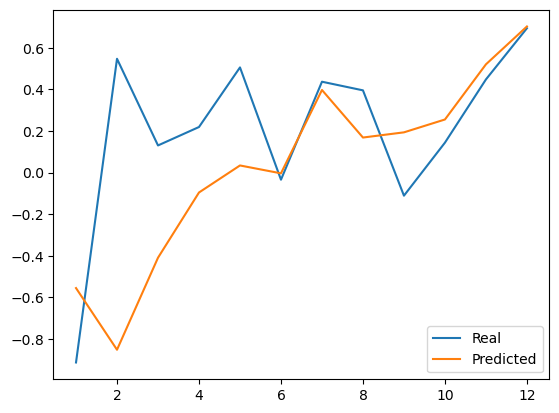

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),73.25,49.13,0.33
MAPE (%),61.64,166.83,1.71


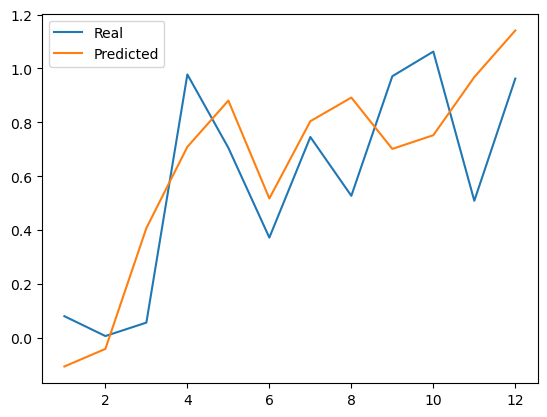

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),75.17,-84.69,2.13
MAPE (%),77.78,36.61,0.53


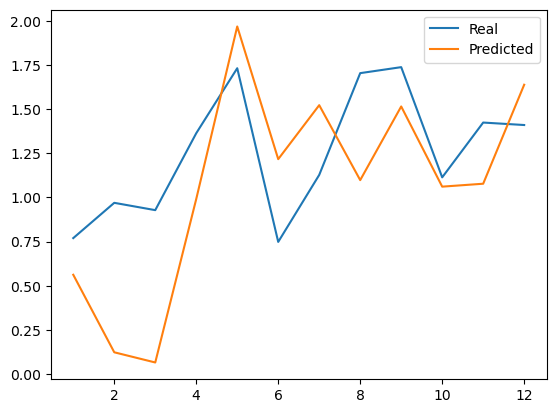

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),74.34,-60.27,1.81
MAPE (%),73.02,36.74,0.50


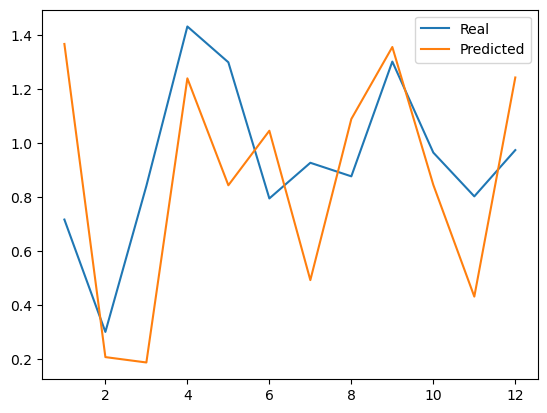

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),73.82,63.55,0.14
MAPE (%),75.24,57.87,0.23


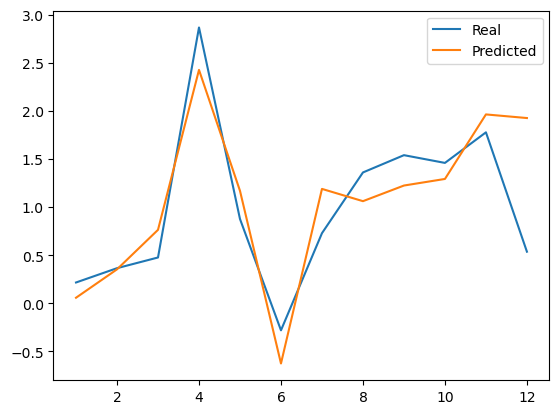

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),75.10,23.53,0.69
MAPE (%),62.05,62.12,0.00


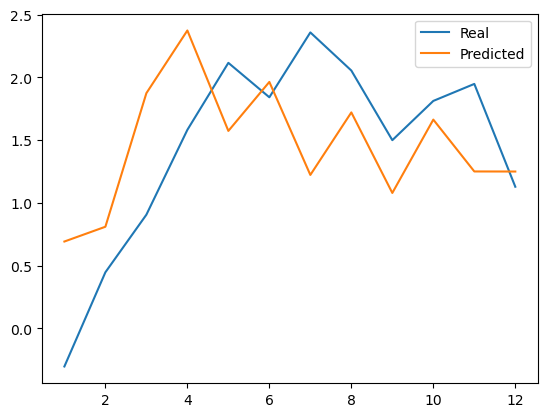

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),75.99,-137.89,2.81
MAPE (%),66.72,222.12,2.33


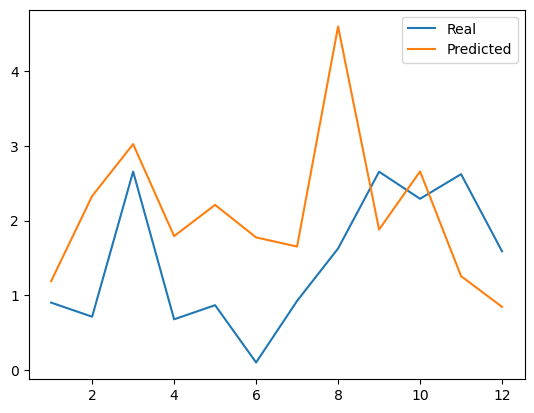

In [118]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_delta_lr[['period','target']+features_list_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.3 Целевая переменная - первые разности темпов прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),50.29,-26.29,1.52
MAPE (%),147.05,130.93,0.11


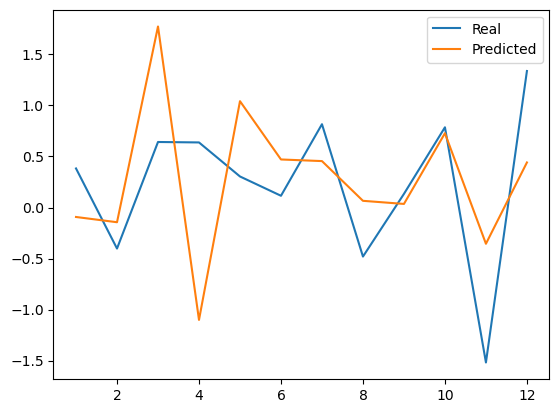

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),49.30,29.32,0.41
MAPE (%),147.69,122.33,0.17


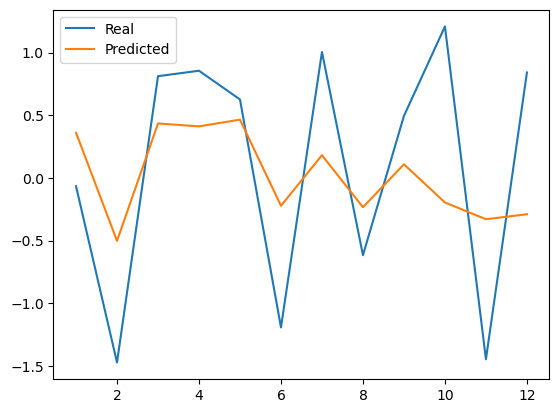

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),52.00,15.63,0.70
MAPE (%),136.55,143.89,0.05


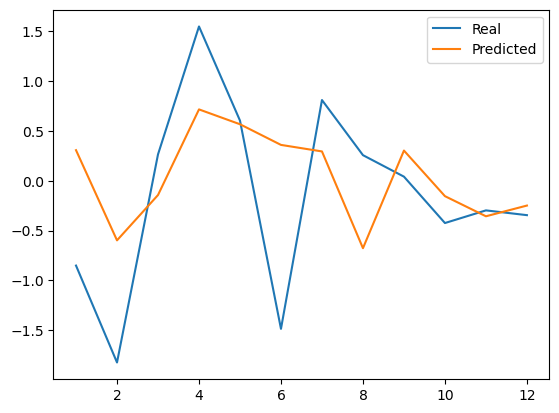

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),49.50,28.88,0.42
MAPE (%),134.72,134.73,0.00


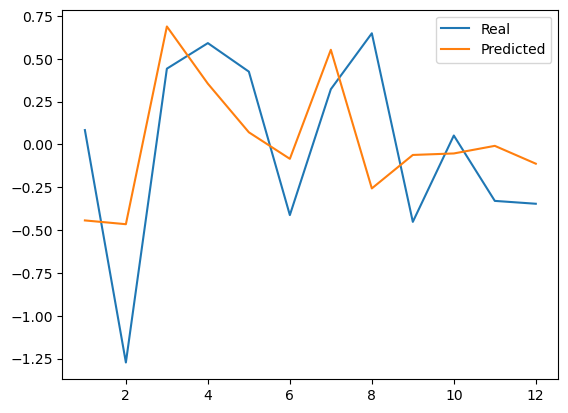

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),48.93,-349.67,8.15
MAPE (%),136.40,159.40,0.17


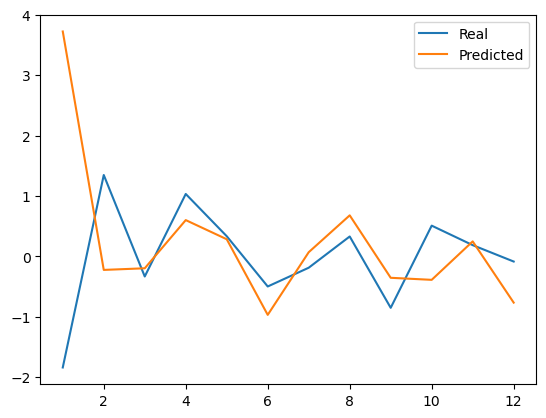

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),48.83,-22.65,1.46
MAPE (%),127.22,383.52,2.01


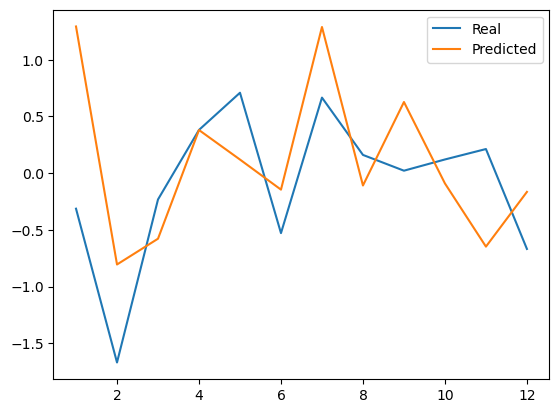

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),50.84,-5.05,1.10
MAPE (%),133.63,94.27,0.29


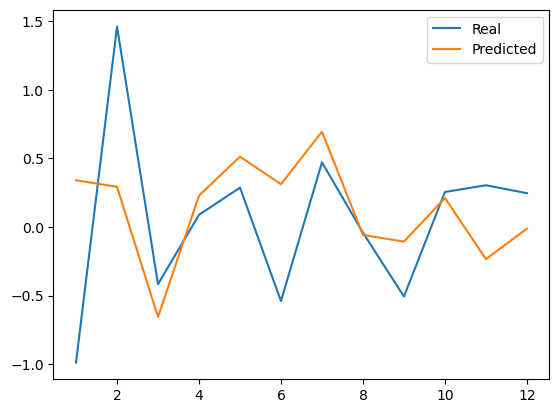

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),49.74,7.66,0.85
MAPE (%),133.93,230.46,0.72


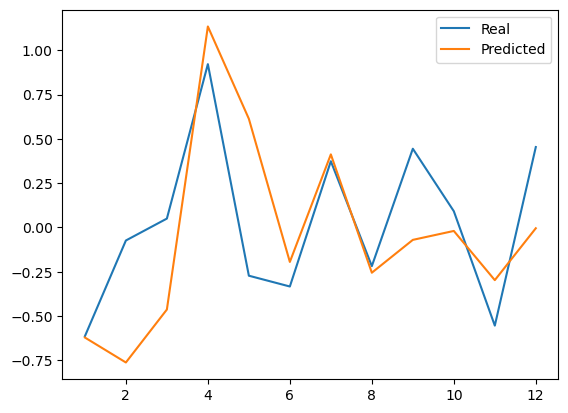

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),49.57,12.56,0.75
MAPE (%),134.47,230.48,0.71


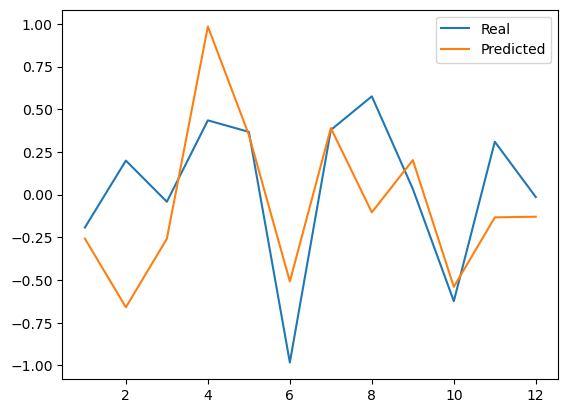

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),49.99,-9.15,1.18
MAPE (%),141.16,84.14,0.40


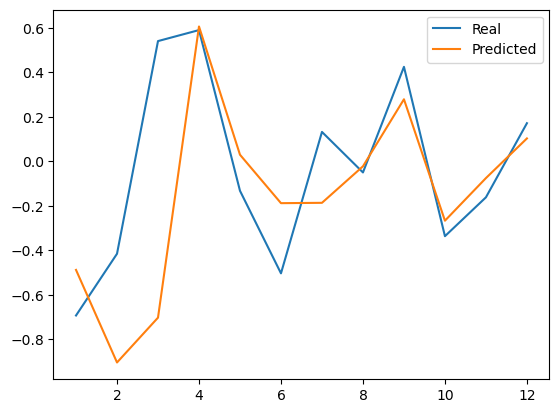

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),45.08,59.08,0.31
MAPE (%),123.66,217.92,0.76


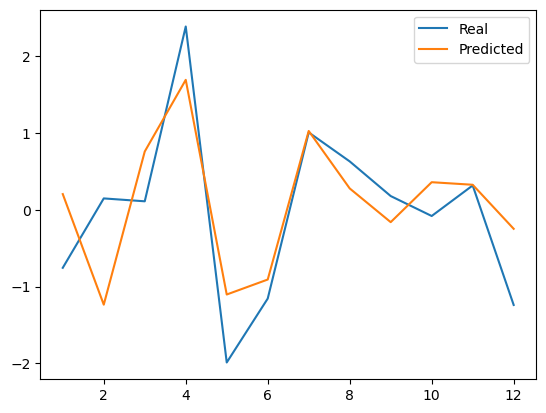

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),52.07,-46.60,1.89
MAPE (%),136.86,139.54,0.02


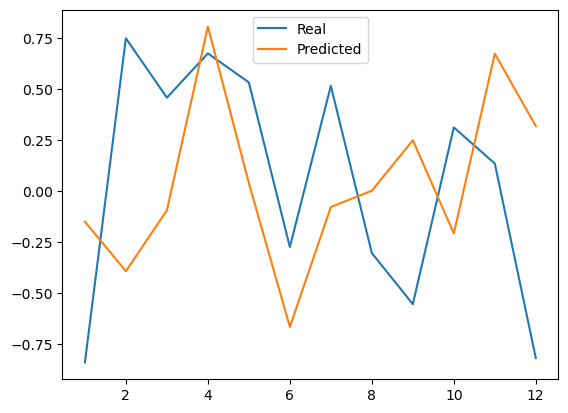

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),50.95,-25.53,1.50
MAPE (%),131.96,241.95,0.83


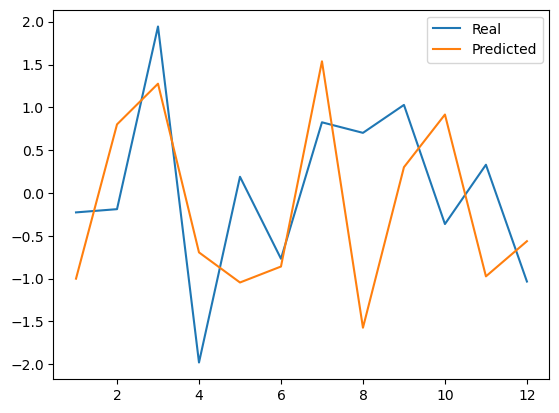

In [119]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_diff_delta_lr[['period','target']+features_list_diff_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()